<a href="https://colab.research.google.com/github/han-juyoung/Aimers_Lectures/blob/main/NLP_Vanilla_RNN%EC%9D%84_%ED%86%B5%ED%95%9C_%ED%95%AD%EA%B3%B5_%EC%8A%B9%EA%B0%9D_%EC%88%98_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

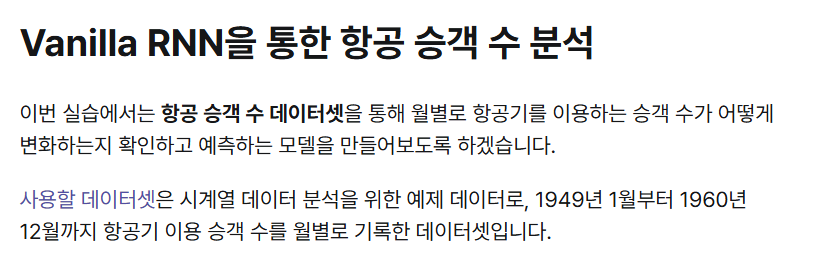

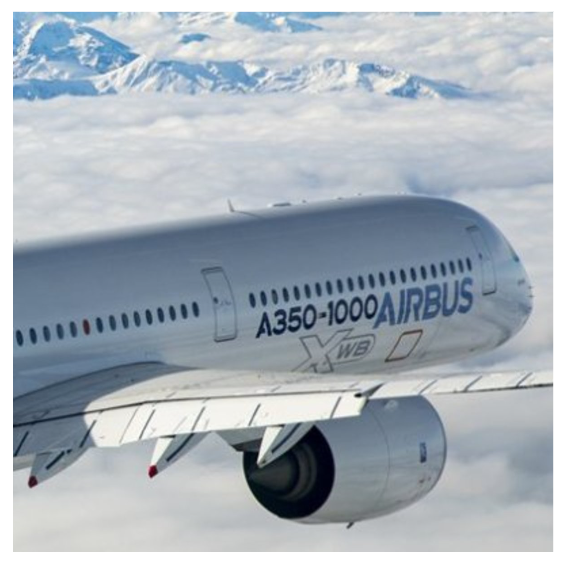

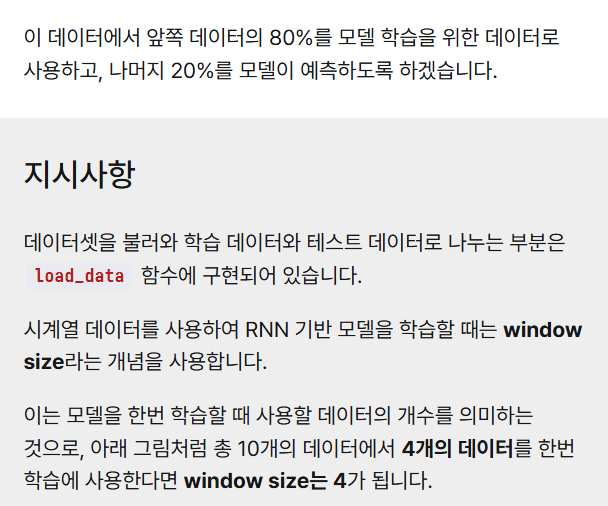

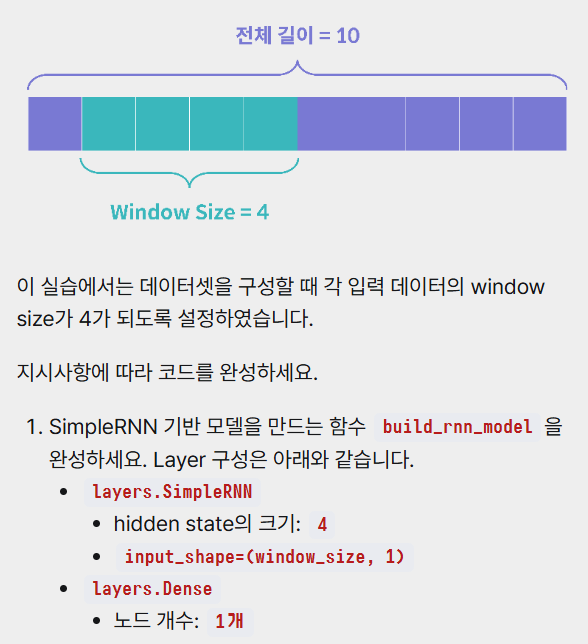

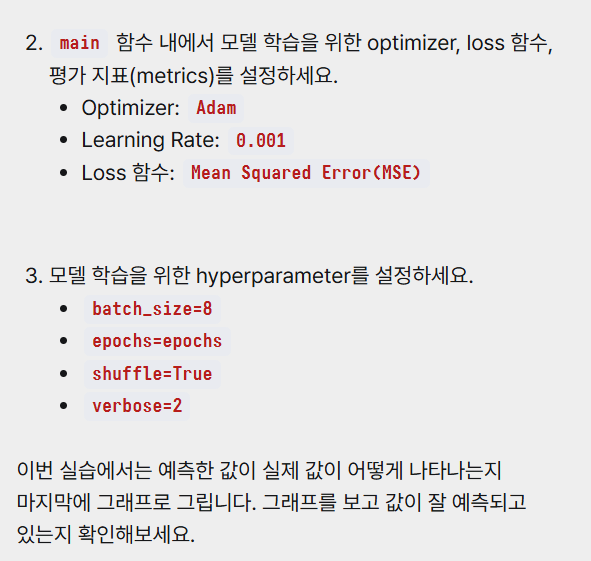

In [ ]:
from elice_utils import EliceUtils

elice_utils = EliceUtils()

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data(window_size):
    raw_data = pd.read_csv("./airline-passengers.csv")
    raw_passengers = raw_data["Passengers"].to_numpy()

    # 데이터의 평균과 표준편차 값으로 정규화(표준화) 합니다.
    mean_passenger = raw_passengers.mean()
    stdv_passenger = raw_passengers.std(ddof=0)
    raw_passengers = (raw_passengers - mean_passenger) / stdv_passenger
    data_stat = {"month": raw_data["Month"], "mean": mean_passenger, "stdv": stdv_passenger}

    # window_size 개의 데이터를 불러와 입력 데이터(X)로 설정하고
    # window_size보다 한 시점 뒤의 데이터를 예측할 대상(y)으로 설정하여
    # 데이터셋을 구성합니다.
    X, y = [], []
    for i in range(len(raw_passengers) - window_size):
        cur_passenger = raw_passengers[i:i + window_size] # 4개라고 한다면
        target = raw_passengers[i + window_size] # 바로 다음인 5번째 값

        X.append(list(cur_passenger))
        y.append(target)

    # X와 y를 numpy array로 변환합니다.
    X = np.array(X)
    y = np.array(y)

    # 각 입력 데이터는 sequence 길이가 window_size이고, featuer 개수는 1개가 되도록
    # 마지막에 새로운 차원을 추가합니다.
    # 즉, (전체 데이터 개수, window_size) -> (전체 데이터 개수, window_size, 1)이 되도록 변환합니다.
    X = X[:, :, np.newaxis]

    # 학습 데이터는 전체 데이터의 80%, 테스트 데이터는 20%로 설정합니다.
    total_len = len(X)
    train_len = int(total_len * 0.8)

    X_train, y_train = X[:train_len], y[:train_len]
    X_test, y_test = X[train_len:], y[train_len:]

    return X_train, X_test, y_train, y_test, data_stat

def build_rnn_model(window_size):
    model = Sequential()

    # TODO: [지시사항 1번] SimpleRNN 기반 모델을 구성하세요.
    model.add(layers.SimpleRNN(4, input_shape=(window_size, 1)))
    # 자연어 데이터가 아니라 embedding layer를 추가하지 않았기 때문에 input_shape을 알려줘야함, (내가 모델에 넣을 시점의 시퀀스길이, feature 사이즈-한시점의 수인데, 승객수만 보니까 1)
    model.add(layers.Dense(1)) # 모델의 출력값을 확률로 바꿀때만 sigmoid 사용함, 승객수 값 자체를 예측하도록 별도의 활성화 함수 사용하지 않음

    return model

def plot_result(X_true, y_true, y_pred, data_stat):
    # 표준화된 결과를 다시 원래 값으로 변환합니다.
    y_true_orig = (y_true * data_stat["stdv"]) + data_stat["mean"]
    y_pred_orig = (y_pred * data_stat["stdv"]) + data_stat["mean"]

    # 테스트 데이터에서 사용한 날짜들만 가져옵니다.
    test_month = data_stat["month"][-len(y_true):]

    # 모델의 예측값을 실제값과 함께 그래프로 그립니다.
    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.plot(y_true_orig, color="b", label="True")
    ax.plot(y_pred_orig, color="r", label="Prediction")
    ax.set_xticks(list(range(len(test_month))))
    ax.set_xticklabels(test_month, rotation=45)
    ax.set_title("RNN Result")
    ax.legend(loc="upper left")
    plt.savefig("airline_rnn.png")
    elice_utils.send_image("airline_rnn.png")

def main(model=None, epochs=10):
    tf.random.set_seed(2022)

    window_size = 4
    X_train, X_test, y_train, y_test, data_stat = load_data(window_size)

    if model is None:
        model = build_rnn_model(window_size)

    # TODO: [지시사항 2번] 모델 학습을 위한 optimizer와 loss 함수를 설정하세요.
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="mse")
    # loss는 분류할때는 crossentropy, 값 자체를 예측할때(회귀분석)는 MSE 사용

    # TODO: [지시사항 3번] 모델 학습을 위한 hyperparameter를 설정하세요.
    hist = model.fit(X_train, y_train, epochs=epochs, batch_size=8, shuffle=True, verbose=2)

    # 테스트 데이터셋으로 모델을 테스트합니다.
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print()
    print("테스트 MSE: {:.5f}".format(test_loss))
    print()

    # 모델의 예측값과 실제값을 그래프로 그립니다.
    y_pred = model.predict(X_test)
    plot_result(X_test, y_test, y_pred, data_stat)

    return optimizer, hist

if __name__ == "__main__":
    main()

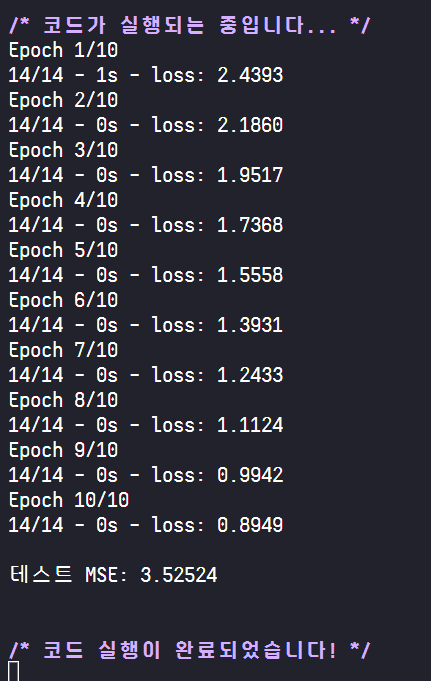

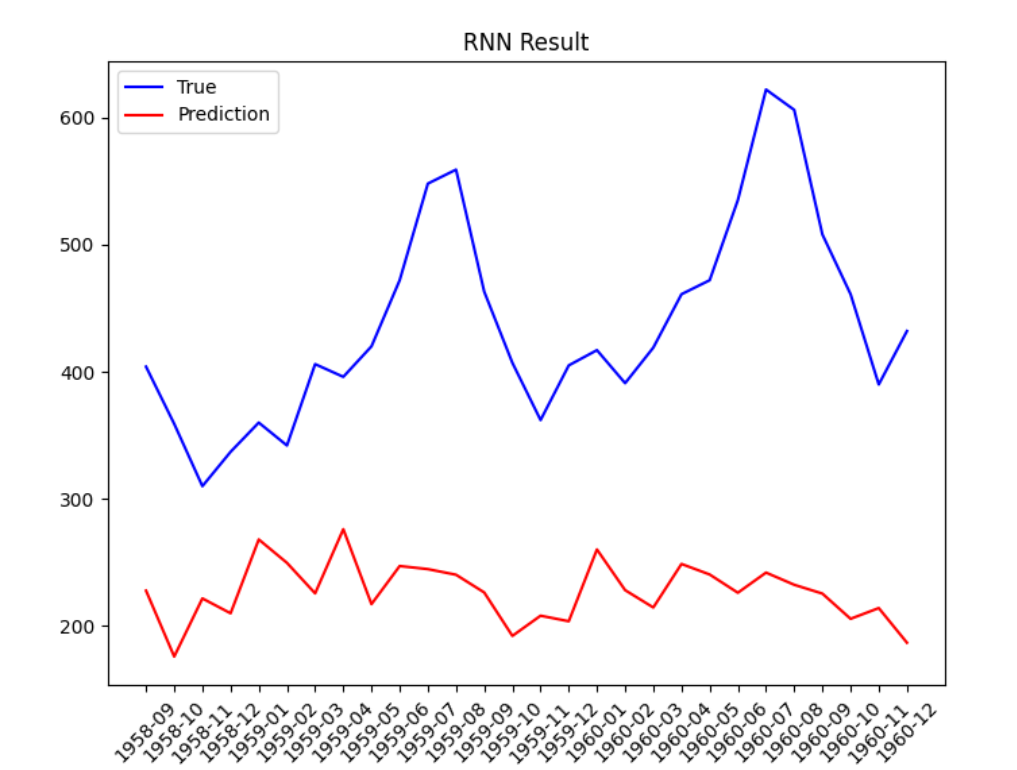

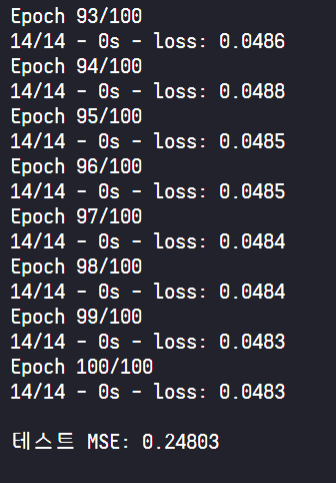

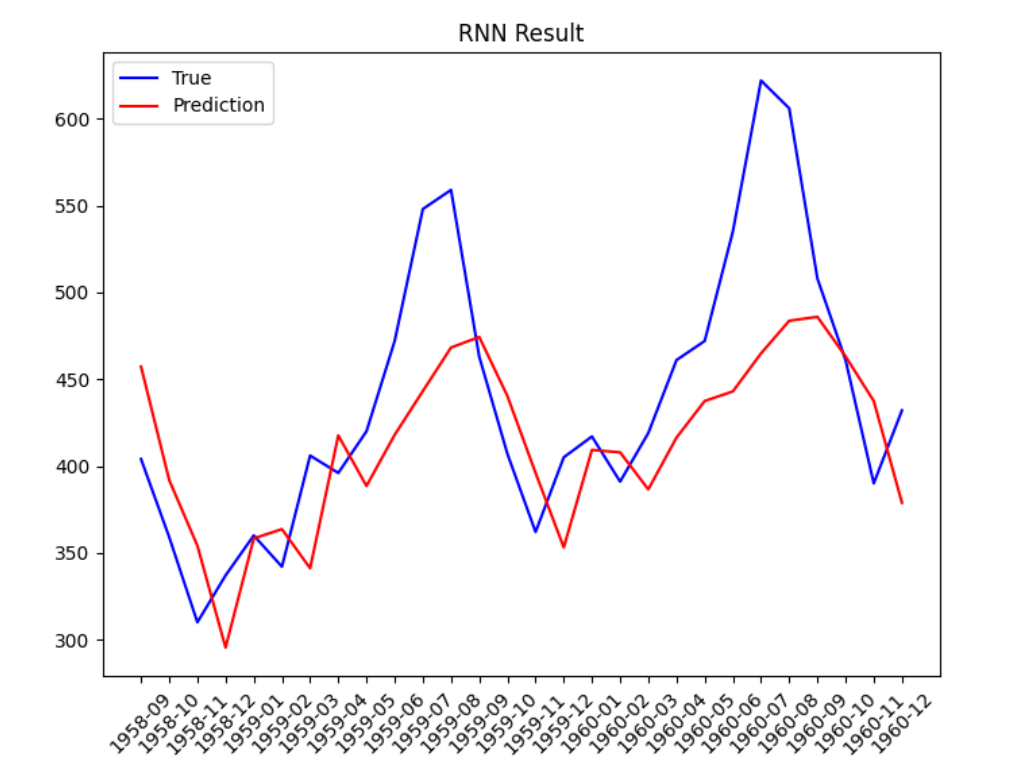